# Прогнозирование оттока клиентов

Оператор связи хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

## Обзор и загрузка данных

Загрузим всё необходимое для работы. 

In [1]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score

from sklearn.metrics import roc_auc_score

from lightgbm import LGBMClassifier

from catboost import CatBoostClassifier

Далее загрузим, изучим и опишем имеющиеся в нашем распоряжении данные.

*Информация о договоре*

In [2]:
df_contracts = pd.read_csv('/datasets/final_provider/contract.csv')

In [3]:
df_contracts.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [4]:
df_contracts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
customerID          7043 non-null object
BeginDate           7043 non-null object
EndDate             7043 non-null object
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


Отсутствуют пропущенные значения. Это однозначно плюс.

Прежде чем продолжить обзор информации о договоре, приведём названия столбцов к более каноничному виду, и изменим тип данных столбца `TotalCharges` на `float64` как для корректного отображения статистических характеристик, так и для дальнейшей работы с этим признаком.

In [5]:
df_contracts.columns = ['customer_id','begin_date','end_date', 'type',
                        'paperless_billing', 'payment_method', 
                        'monthly_charges', 'total_charges']

Изменим тип данных `total_charges` на `float`

In [6]:
df_contracts['total_charges'] = pd.to_numeric(df_contracts['total_charges'], errors='coerce')

Проверим наличие возможных пропусков после изменения типа данных

In [7]:
df_contracts['total_charges'].isnull().sum()

11

Не критично для того, чтобы просто удалить этих клиентов.

In [8]:
df_contracts.dropna(inplace = True)

Оценим статистические характеристики для признаков `monthly_charges` и `total_charges`.

In [9]:
df_contracts.describe()

,monthly_charges,total_charges
count,7032.000000,7032.000000
mean,64.798208,2283.300441
std,30.085974,2266.771362
min,18.250000,18.800000
25%,35.587500,401.450000
50%,70.350000,1397.475000
75%,89.862500,3794.737500
max,118.750000,8684.800000


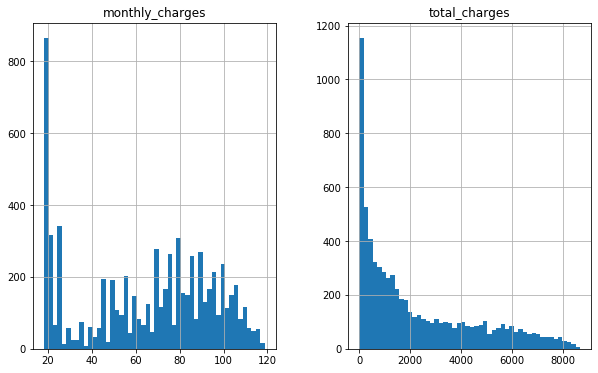

In [10]:
df_contracts.hist(bins = 50, figsize = (10,6));

Из полученных характеристик и гистограмм отлично видно, что большое число клиентов совершают минимальные платы как в месячном, так и в суммарном выражении.

Рассмотрим теперь каждый признак в отдельности

`customer_id` - уникальный идентификатор клиента. Известно, что этот признак общий для всех имеющихся в нашем распоряжении таблиц и следовательно он будет использован для сборки всей информации в один датафрейм.

На данном этапе, пожалуй, будет сразу не лишним проверить таблицу на дубликаты. Отправной точкой будет именно этот признак.

In [11]:
df_contracts['customer_id'].value_counts(ascending = False).head()

2277-AXSDC    1
1269-FOYWN    1
2882-DDZPG    1
6615-ZGEDR    1
9565-AXSMR    1
Name: customer_id, dtype: int64

Отлично. Никаких дубликатов.

`begin_date` - дата заключения договора. Пригодится нам для создания нового признака: времени жизни клиента.

`end_date` - дата окончания договора. Наш целевой признак. Точнее станет им после некоторых преобразований. Также необходим для создания вышеуказанного признака.

`type` - тип платежа.

In [12]:
df_contracts['type'].value_counts(normalize = True) * 100

Month-to-month    55.105233
Two year          23.961889
One year          20.932878
Name: type, dtype: float64

Всего три типа: 

    1) каждый месяц
    2) абонемент на год
    3) абонемент на два года
    
Самый распространённый вариант платежа - ежемесячный.

`paperless_billing` - получение электронного чека.

In [13]:
df_contracts['paperless_billing'].value_counts(normalize = True) * 100

Yes    59.2719
No     40.7281
Name: paperless_billing, dtype: float64

Большая часть клиентов предпочитает иметь дело с цифровым вариантом чека.

`payment_method` - способ оплаты.

In [14]:
df_contracts['payment_method'].value_counts(normalize = True) * 100

Electronic check             33.631968
Mailed check                 22.810011
Bank transfer (automatic)    21.928328
Credit card (automatic)      21.629693
Name: payment_method, dtype: float64

Платить по электронному чеку предпочитает треть клиентов, остальных почти поровну.

`monthly_charges` - ежемесячный платёж. Из представленной статистики по этому признаку видно, что 25% клиентов платят меньше 35,59$ в месяц, остальная же часть, начиная с этой отметки, распределена нормально.

`total_charges` - сколько всего принёс клиент денег с момента заключения договора до момента выгрузки данных. Здесь мы также видим сильное смещение клиентской базы в первый квартиль до 401,45$.

*Персональные данные*

In [15]:
df_personal = pd.read_csv('/datasets/final_provider/personal.csv')

In [16]:
df_personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [17]:
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
customerID       7043 non-null object
gender           7043 non-null object
SeniorCitizen    7043 non-null int64
Partner          7043 non-null object
Dependents       7043 non-null object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


Ни одного пропуска. Также переименуем названия столбцов и далее рассмотрим имеющиеся признаки.

In [18]:
df_personal.columns = ['customer_id','gender','senior_citizen', 'partner', 'dependents']

`customer_id` - идентификатор пользователя. Проверим данные на дубликаты.

In [19]:
df_personal['customer_id'].value_counts(ascending = False).head()

2277-AXSDC    1
5808-TOTXO    1
1335-NTIUC    1
2882-DDZPG    1
6615-ZGEDR    1
Name: customer_id, dtype: int64

Дубликатов не обнаружено.

`gender` - пол.

In [20]:
df_personal['gender'].value_counts(normalize = True) * 100

Male      50.47565
Female    49.52435
Name: gender, dtype: float64

Почти поровну.

`senior_citizen` - пенсионер клиент или нет.

In [21]:
df_personal['senior_citizen'].value_counts(normalize = True) * 100

0    83.785319
1    16.214681
Name: senior_citizen, dtype: float64

Пенсионеров, ожидаемо, не много.

`partner` - состоит ли клиент в отношениях.

In [22]:
df_personal['partner'].value_counts(normalize = True) * 100

No     51.69672
Yes    48.30328
Name: partner, dtype: float64

`dependents`- является ли клиент иждивенцем.

In [23]:
df_personal['dependents'].value_counts(normalize = True) * 100

No     70.041176
Yes    29.958824
Name: dependents, dtype: float64

Подавляющее большинство - нет.

*Информация об интернет-услугах*

In [24]:
df_internet = pd.read_csv('/datasets/final_provider/internet.csv')

In [25]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
customerID          5517 non-null object
InternetService     5517 non-null object
OnlineSecurity      5517 non-null object
OnlineBackup        5517 non-null object
DeviceProtection    5517 non-null object
TechSupport         5517 non-null object
StreamingTV         5517 non-null object
StreamingMovies     5517 non-null object
dtypes: object(8)
memory usage: 344.9+ KB


In [26]:
df_internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [27]:
df_internet.columns = ['customer_id','internet_service','online_security', 'online_backup', 
                       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']

`customer_id` - идентификатор клиента. Снова оценим наличие дубликатов.

In [28]:
df_internet['customer_id'].value_counts(ascending = False).head()

5996-EBTKM    1
6362-QHAFM    1
2344-JMOGN    1
6614-VBEGU    1
5233-GEEAX    1
Name: customer_id, dtype: int64

И опять таковые отсутствуют.

`internet_service` - тип подключения интернета у клиента.

In [29]:
df_internet['internet_service'].value_counts(normalize = True) * 100

Fiber optic    56.117455
DSL            43.882545
Name: internet_service, dtype: float64

Fiber optic - имеет небольшое преимущество.

`online_security` - использует ли клиент опцию блокировки небезопасных сайтов.

In [30]:
df_internet['online_security'].value_counts(normalize = True) * 100

No     63.404024
Yes    36.595976
Name: online_security, dtype: float64

2/3 клиентов предпочитают обходиться без данной опции.

`online_backup` - использует ли клиент облачное хранилище файлов для резервного копирования данных.

In [31]:
df_internet['online_backup'].value_counts(normalize = True) * 100

No     55.972449
Yes    44.027551
Name: online_backup, dtype: float64

Больше -  нет, чем - да.

`device_protection` - использует ли клиент антивирус.

In [32]:
df_internet['device_protection'].value_counts(normalize = True) * 100

No     56.099329
Yes    43.900671
Name: device_protection, dtype: float64

Чуть меньше половины антивирус всё таки используют.

`tech_support`- использует ли клиент опцию выделенной линии технической поддержки.

In [33]:
df_internet['tech_support'].value_counts(normalize = True) * 100

No     62.950879
Yes    37.049121
Name: tech_support, dtype: float64

Большая часть клиентов в выделенной линии технической поддержки не нуждаются.

`streaming_tv` - использует ли клиент опцию стримингового телевидения.

In [34]:
df_internet['streaming_tv'].value_counts(normalize = True) * 100

No     50.933478
Yes    49.066522
Name: streaming_tv, dtype: float64

Для половины пользователей лишняя опция.

`streaming_movies` - использует ли клиент каталог фильмов.

In [35]:
df_internet['streaming_movies'].value_counts(normalize = True) * 100

No     50.480334
Yes    49.519666
Name: streaming_movies, dtype: float64

И снова, только 50% интересен каталог фильмов.

*Информация об услугах телефонии*

In [36]:
df_phone = pd.read_csv('/datasets/final_provider/phone.csv')

In [37]:
df_phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [38]:
df_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
customerID       6361 non-null object
MultipleLines    6361 non-null object
dtypes: object(2)
memory usage: 99.5+ KB


In [39]:
df_phone.columns = ['customer_id','multiple_lines']

`customer_id` - идентификатор клиента.

In [40]:
df_phone['customer_id'].value_counts(ascending = False).head()

2277-AXSDC    1
5419-KLXBN    1
2495-TTHBQ    1
6328-ZPBGN    1
2351-BKRZW    1
Name: customer_id, dtype: int64

И здесь также без дубликатов.

`multiple_lines` - пользуется ли клиент услугой подключения нескольких линий одновременно.

In [41]:
df_phone['multiple_lines'].value_counts(normalize = True) * 100

No     53.293507
Yes    46.706493
Name: multiple_lines, dtype: float64

**Вывод**

На данном этапе был проведён первичный анализ имеющихся в нашем распоряжении данных. Названия столбцов и тип данных в случае с `monthly_charges` были приведен к рабочему виду. Составлен план действий, для решения поставленной задачи.

**План**

1. **Подготовка данных**: объединим имеющиеся таблицы в один фрейм по столбцу `customer_id`. Создадим новые признаки, удалив при этом лишние. С помощью техники `Ordinal Encoding` произведём перевод текстовых значений в числовую форму. 
2. **Анализ и разделение данных на выборки**: проанализируем целевой признак на предмет дисбаланса классов. В случае наличия такового, подберем оптимальную технику для решения этой проблемы. Разделим фрейм на выборки. 
3. **Построение модели и выбор наилучшей**: построим несколько классификаторов разных видов. Подберём гиперпараметры для получения необходимо значения метрики `ROC-AUC`. Также выведим значения `accuracy`.
4. **Вывод**: опишем полученные результаты.

## Подготовка данных

**Создание признаков**

На основе данных признака `end_date` зададим целевой признак.

In [42]:
def make_target(data): 
    if data == 'No':
        data = 0
    else: 
        data = 1
    return data

In [43]:
df_contracts['exited'] = df_contracts['end_date'].apply(make_target)

Далее создадим признак `customer_lifetime` - время жизни клиента.

Для этого в первую очередь заменим в столбце `end_date` все значения `No`, на дату выгрузки данных `01.02.2020`.

In [44]:
df_contracts['end_date'].replace('No','2020-02-01', inplace = True)

Далее для признаков `begin_date` и `end_date` изменим формат данных на `datetime`.

In [45]:
df_contracts['begin_date'] = pd.to_datetime(df_contracts['begin_date'])

In [46]:
df_contracts['end_date'] = pd.to_datetime(df_contracts['end_date'])

Теперь посчитаем разницу между этими признаками и приведём данные к соответствующему формату в четырёх вариантах: дни, недели, месяцы, годы.

In [47]:
df_contracts['customer_lifetime_days'] = (df_contracts['end_date'] 
                                          - df_contracts['begin_date']).dt.days

In [48]:
df_contracts['customer_lifetime_weeks'] = ((df_contracts['end_date'] - df_contracts['begin_date']) 
                                            / np.timedelta64(1, 'W'))

In [49]:
df_contracts['customer_lifetime_months'] = ((df_contracts['end_date'] - df_contracts['begin_date']) 
                                            / np.timedelta64(1, 'M'))

In [50]:
df_contracts['customer_lifetime_years'] = ((df_contracts['end_date'] - df_contracts['begin_date'])
                                              / np.timedelta64(1, 'Y'))

Прежде чем приступить к дальнейшим расчётам, удалим признаки `begin_date` и `end_date`.

In [51]:
df_contracts.drop(columns=['begin_date', 'end_date'], inplace = True)

Далее создадим признаки отражающие прибыль, которую приносит клиент в единицу времени. За единицу времени будут взяты величины рассчитанные выше. 

In [52]:
df_contracts['total_per_day'] = (df_contracts['total_charges'] 
                                 / df_contracts['customer_lifetime_days'])

In [53]:
df_contracts['total_per_week'] = (df_contracts['total_charges'] 
                                  / df_contracts['customer_lifetime_weeks'])

In [54]:
df_contracts['total_per_month'] = (df_contracts['total_charges'] 
                                   / df_contracts['customer_lifetime_months'])

In [55]:
df_contracts['total_per_year'] = (df_contracts['total_charges'] 
                                  / df_contracts['customer_lifetime_years'])

**Объединение таблиц и кодирование категориальных признаков**

Объединим имеющиеся в нашем распоряжении таблицы в единый фрейм.

In [56]:
df = pd.merge(df_contracts, df_personal, how='left')

In [57]:
df = pd.merge(df, df_internet, how='left')

In [58]:
df = pd.merge(df, df_phone, how='left')

In [59]:
df.isnull().sum()

customer_id                    0
type                           0
paperless_billing              0
payment_method                 0
monthly_charges                0
total_charges                  0
exited                         0
customer_lifetime_days         0
customer_lifetime_weeks        0
customer_lifetime_months       0
customer_lifetime_years        0
total_per_day                  0
total_per_week                 0
total_per_month                0
total_per_year                 0
gender                         0
senior_citizen                 0
partner                        0
dependents                     0
internet_service            1520
online_security             1520
online_backup               1520
device_protection           1520
tech_support                1520
streaming_tv                1520
streaming_movies            1520
multiple_lines               680
dtype: int64

Исходя из размеров объединяемых таблиц ожидаемо получили пропуски в общем датафрейме. Пропуски при применении техники `Ordinal Encoding` заменим на ещё одну категорию.

In [60]:
columns_enc = ['type','paperless_billing','payment_method','partner','dependents', 'internet_service', 'gender',
                'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
              'multiple_lines']

In [61]:
df.fillna(value = 'No', inplace = True)

In [62]:
encoder = OrdinalEncoder()

In [63]:
df_enc = pd.DataFrame(encoder.fit_transform(df[columns_enc]), columns=columns_enc)

In [64]:
df.drop(columns_enc, axis = 1, inplace = True)

In [65]:
df = df.join(df_enc)

Проверим полученный результат.

In [66]:
df.head(5)

,customer_id,monthly_charges,total_charges,exited,customer_lifetime_days,customer_lifetime_weeks,customer_lifetime_months,customer_lifetime_years,total_per_day,total_per_week,...,dependents,internet_service,gender,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,29.85,29.85,0,31,4.428571,1.018501,0.084875,0.962903,6.740323,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,5575-GNVDE,56.95,1889.50,0,1036,148.000000,34.037660,2.836472,1.823842,12.766892,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,3668-QPYBK,53.85,108.15,1,61,8.714286,2.004148,0.167012,1.772951,12.410656,...,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
3,7795-CFOCW,42.30,1840.75,0,1371,195.857143,45.044046,3.753671,1.342633,9.398432,...,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
4,9237-HQITU,70.70,151.65,1,61,8.714286,2.004148,0.167012,2.486066,17.402459,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 27 columns):
customer_id                 7032 non-null object
monthly_charges             7032 non-null float64
total_charges               7032 non-null float64
exited                      7032 non-null int64
customer_lifetime_days      7032 non-null int64
customer_lifetime_weeks     7032 non-null float64
customer_lifetime_months    7032 non-null float64
customer_lifetime_years     7032 non-null float64
total_per_day               7032 non-null float64
total_per_week              7032 non-null float64
total_per_month             7032 non-null float64
total_per_year              7032 non-null float64
senior_citizen              7032 non-null int64
type                        7032 non-null float64
paperless_billing           7032 non-null float64
payment_method              7032 non-null float64
partner                     7032 non-null float64
dependents                  7032 non-null float64


Отлично. Всё в соответствии с задуманным.

Признак `customer_id` нам больше не нужен: таблицы объединены, а роль идентификатора теперь выполняет индекс.

In [68]:
df.drop(labels = 'customer_id', inplace = True, axis = 1)

Перед тем как преступить к обучению моделей, проведём оценку количественных признаков на мультиколлинеарность, а также проведём анализ важности признаков.

Выделим из нашего фрейма количественные признаки.

In [69]:
df_quantitative = (df.loc[:,'monthly_charges':'total_per_year']
                   .drop(labels = 'exited', axis = 1))

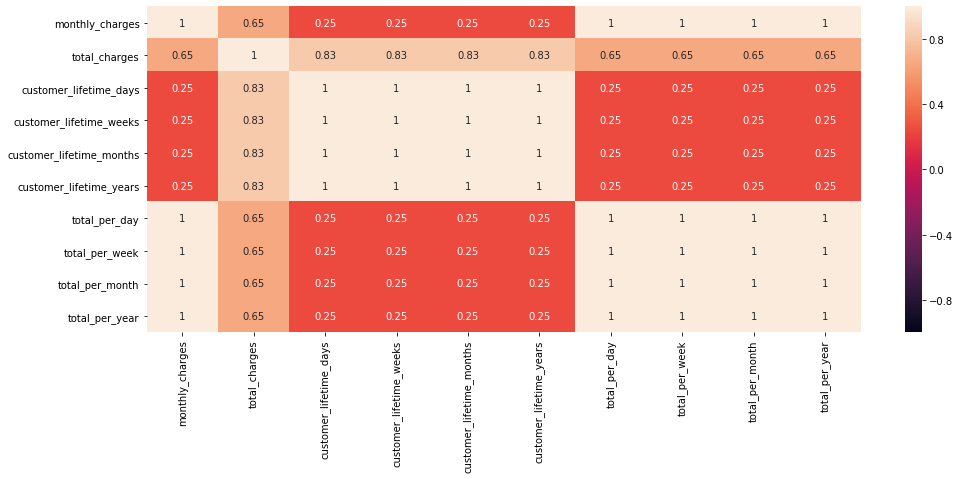

In [70]:
plt.figure(figsize=(16, 6)) 
sns.heatmap(df_quantitative.corr(), vmin=-1, vmax=1, annot=True)


Итак. Получаем, что все созданные до этого признаки отлично коррелируют не только друг с другом, но и другими двумя количественными признаками. Очевидно, предстоит убрать лишние признаки, но сделаем мы это не сейчас, а после анализа важности признаков, оствавив в итоге наиболее значимый. 

## Обучение модели

Прежде чем переходить к обучению модели проанализируем наш целевой признак на предмет дисбаланса классов.

In [71]:
df['exited'].mean()

0.26578498293515357

Ситуация далека от идеальной, поэтому при построении моделей произведём взвешивание весов, указав гиперпараметр `class_weight = 'balanced'`. 

Создадим обучающую, валидационную и тестовую выборки в пропорции 60% / 20% / 20%.

In [72]:
df_train, df_other = train_test_split(df, test_size = 0.40, random_state = 12345)

In [73]:
df_valid, df_test = train_test_split(df_other, test_size = 0.50, random_state = 12345)

In [74]:
features_train = df_train.drop(['exited'], axis=1)
target_train = df_train['exited']

In [75]:
features_train.shape

(4219, 25)

In [76]:
features_valid = df_valid.drop(['exited'], axis=1)
target_valid = df_valid['exited']

In [77]:
features_valid.shape

(1406, 25)

In [78]:
features_test = df_test.drop(['exited'], axis=1)
target_test = df_test['exited']

In [79]:
features_test.shape

(1407, 25)

Перейдём к обучению моделей.

**DecisionTreeClassifier**

In [80]:
best_model = None
best_result_roc_auc_tree = 0

for depth in range(1,30): 
    
    model = DecisionTreeClassifier(random_state=12345
                                   , max_depth= depth
                                   , class_weight = 'balanced' )
    model.fit(features_train,target_train)
    predictions_valid = model.predict(features_valid)
    accuracy = accuracy_score(target_valid, predictions_valid)
    
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    result_roc_auc = roc_auc_score(target_valid, probabilities_one_valid)
    
    if result_roc_auc > best_result_roc_auc_tree:
        best_model = model 
        best_depth = depth
        best_accuracy_tree = accuracy
        best_result_roc_auc_tree = result_roc_auc

print("Best_depth = ", best_depth)    
print("Accuracy = ", best_accuracy_tree)
print("AUC-ROC = ", best_result_roc_auc_tree) 

Best_depth =  5
Accuracy =  0.7837837837837838
AUC-ROC =  0.8491206437965988


**RandomForestClassifier**

In [81]:
best_model = None
best_result_roc_auc_forest = 0

for est in range(10, 200, 10): 
    
    model = RandomForestClassifier(random_state=12345,
                                    n_estimators= est,
                                    class_weight = 'balanced',
                                    criterion = 'entropy')
    model.fit(features_train,target_train)
    predictions_valid = model.predict(features_valid)
    accuracy = accuracy_score(target_valid, predictions_valid)
    
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    result_roc_auc = roc_auc_score(target_valid, probabilities_one_valid)
    
    if result_roc_auc > best_result_roc_auc_forest:
        best_model = model 
        best_est = est
        best_accuracy_forest = accuracy
        best_result_roc_auc_forest = result_roc_auc

print("Best_est = ", best_est)    
print("Accuracy = ", best_accuracy_forest)
print("AUC-ROC = ", best_result_roc_auc_forest) 

Best_est =  180
Accuracy =  0.8392603129445235
AUC-ROC =  0.8828445694060484


**LogisticRegression**

In [82]:
best_model = None
best_result_roc_auc_log_reg = 0

for c in np.arange(0.1, 1.0, 0.1):
    for tol in np.arange(0.00002, 0.00042, 0.00002):
        model = LogisticRegression(random_state=12345,
                                    C = c,
                                    tol = tol,
                                    class_weight = 'balanced',
                                    solver = 'liblinear')
        
        model.fit(features_train,target_train)
        predictions_valid = model.predict(features_valid)
        accuracy = accuracy_score(target_valid, predictions_valid)
    
        probabilities_valid = model.predict_proba(features_valid)
        probabilities_one_valid = probabilities_valid[:, 1]
        result_roc_auc = roc_auc_score(target_valid, probabilities_one_valid)

        if result_roc_auc > best_result_roc_auc_log_reg:
            best_model = model 
            best_c = c
            best_tol = tol
            best_accuracy_log_reg = accuracy
            best_result_roc_auc_log_reg = result_roc_auc 
                            
print("Best_C = ", best_c)
print("Best_tol = ", best_tol)
print("Accuracy = ", best_accuracy_log_reg)
print("AUC-ROC = ", best_result_roc_auc_log_reg) 

Best_C =  0.2
Best_tol =  8e-05
Accuracy =  0.7290184921763869
AUC-ROC =  0.8529388665493842


**LGBMClassifier**

In [83]:
best_model_lgbm = None
best_result_roc_auc_lgbm = 0

for n in range(100,501,50):
    model = LGBMClassifier(random_state=12345,
                           n_estimators = n,
                           class_weight = 'balanced')
        
    model.fit(features_train,target_train)
    predictions_valid = model.predict(features_valid)
    accuracy = accuracy_score(target_valid, predictions_valid)
    
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    result_roc_auc = roc_auc_score(target_valid, probabilities_one_valid)

    if result_roc_auc > best_result_roc_auc_lgbm:
        best_model_lgbm = model 
        best_accuracy_lgbm = accuracy
        best_n_estimators = n
        best_result_roc_auc_lgbm = result_roc_auc 
                    
print("Best_n_estimators = ", best_n_estimators)
print("Accuracy = ", best_accuracy_lgbm)
print("AUC-ROC = ", best_result_roc_auc_lgbm) 

Best_n_estimators =  250
Accuracy =  0.8520625889046942
AUC-ROC =  0.9100642958867388


**CatBoostClassifier**

In [84]:
class_1 = target_train.sum()

In [85]:
class_0 = target_train.count() - target_train.sum()

In [86]:
best_model_cat = None
best_result_roc_auc_cat = 0

for n in range(100,501,50):
    
    model_cat = CatBoostClassifier(loss_function="Logloss", 
                                   iterations= n, 
                                   random_seed = 12345,
                                   scale_pos_weight = class_0 / class_1,
                                   boosting_type = 'Ordered')

    model_cat.fit(features_train,target_train,verbose = False)
    predictions_valid = model_cat.predict(features_valid)
    accuracy = accuracy_score(target_valid, predictions_valid)

    probabilities_valid = model_cat.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    result_roc_auc = roc_auc_score(target_valid, probabilities_one_valid)

    if result_roc_auc > best_result_roc_auc_cat:
        best_model_cat = model_cat 
        best_accuracy_cat = accuracy
        best_n_iterations = n
        best_result_roc_auc_cat = result_roc_auc    
    
print("Best_n_iterations = ", best_n_iterations)
print("Accuracy = ", best_accuracy_cat)
print("AUC-ROC = ", best_result_roc_auc_cat)

Best_n_iterations =  350
Accuracy =  0.8214793741109531
AUC-ROC =  0.9134034409818212


Сведём полученные результаты в единую таблицу

In [87]:
list_results = [
    ['DecisionTreeClassifier', best_accuracy_tree, best_result_roc_auc_tree],
    ['RandomForestClassifier', best_accuracy_forest, best_result_roc_auc_forest],
    ['LogisticRegression',best_accuracy_log_reg, best_result_roc_auc_log_reg],
    ['LGBMClassifier', best_accuracy_lgbm, best_result_roc_auc_lgbm],
    ['CatBoostClassifier', best_accuracy_cat, best_result_roc_auc_cat]]

In [88]:
df_results = pd.DataFrame(list_results, columns = ['name','accuracy','roc_auc'])

In [89]:
df_results.sort_values(by = ['roc_auc'], ascending = False)

,name,accuracy,roc_auc
4,CatBoostClassifier,0.821479,0.913403
3,LGBMClassifier,0.852063,0.910064
1,RandomForestClassifier,0.839260,0.882845
2,LogisticRegression,0.729018,0.852939
0,DecisionTreeClassifier,0.783784,0.849121


**Анализ мультиколлинеарности и значимости признаков** 

Как видно из представленной сводной таблицы, нашим лучшим классификатором стал **`CatBoostClassifier`**, следовательно на нём и продолжим работу с признаками. Посмотрим распределение признаков по их значимости для прогноза целевого признака.

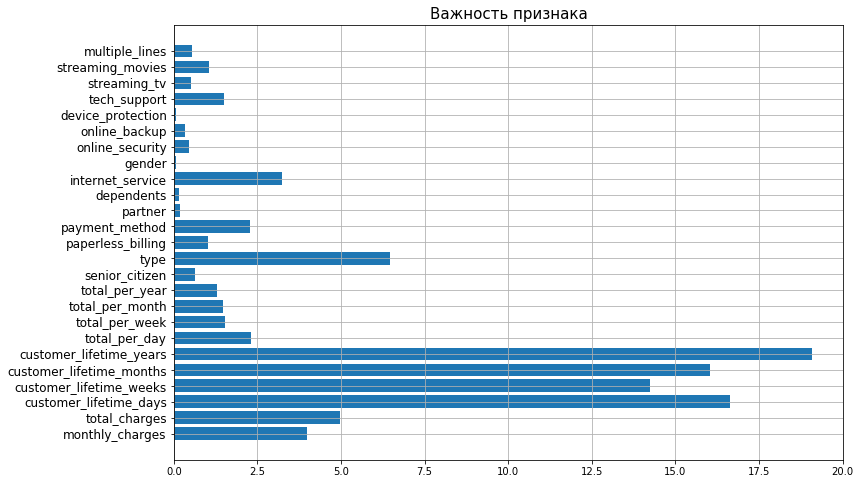

In [90]:
x = features_train.columns.tolist()
y = best_model_cat.feature_importances_

fig, ax = plt.subplots()

ax.barh(x, y)

ax.set_yticks(x)
ax.set_yticklabels(x, fontsize = 12)

fig.set_figwidth(12)
fig.set_figheight(8)
ax.set_title('Важность признака', fontsize = 15)
ax.grid()

plt.show()

Привём таблицу корреляции признаков повторно.

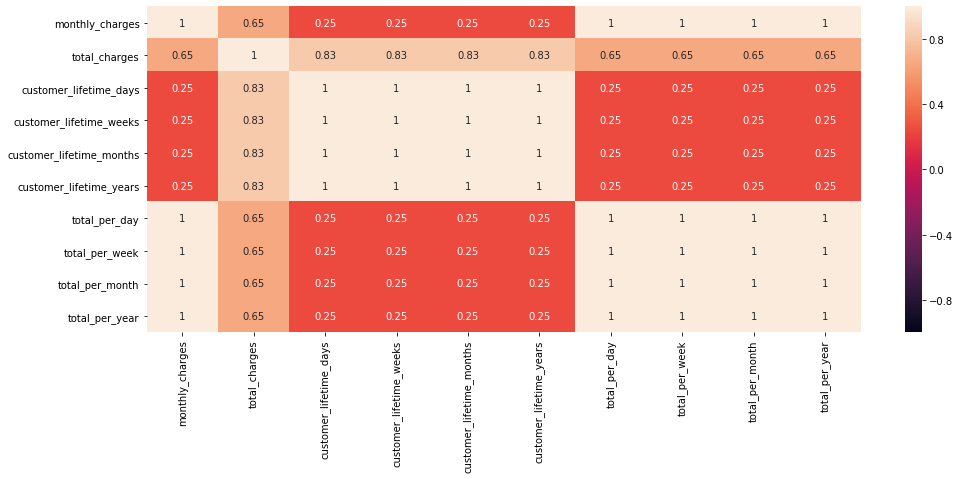

In [91]:
plt.figure(figsize=(16, 6)) 
sns.heatmap(df_quantitative.corr(), vmin=-1, vmax=1, annot=True)

Как видно из графика и таблицы, наш самый весомый признак это `customer_lifetime_years`, который в свою очередь даёт корреляцию меньше 0.8 только с `monthly_charges`. Собственно, из количественных признаков эти два только и оставим. 

Также удалим несколько категориальных признаков с незначительным влиянием. В реальных условиях любая информация стоит денег, поэтому оставим только необходимое.

In [92]:
df.drop(labels = ['customer_lifetime_weeks', 
                  'customer_lifetime_months',
                  'customer_lifetime_days',
                  'total_per_year',
                  'total_per_month',
                  'total_per_week',
                  'total_per_day',
                  'total_charges',
                  'gender',
                  'device_protection',
                  'online_backup', 
                  'online_security',
                  'dependents',
                  'partner'], inplace = True, axis = 1)

Повторно создадим необходимые выборки.

In [93]:
df_train, df_other = train_test_split(df, test_size = 0.40, random_state = 12345)

In [94]:
df_valid, df_test = train_test_split(df_other, test_size = 0.50, random_state = 12345)

In [95]:
features_train = df_train.drop(['exited'], axis=1)
target_train = df_train['exited']

In [96]:
features_train.shape

(4219, 11)

In [97]:
features_valid = df_valid.drop(['exited'], axis=1)
target_valid = df_valid['exited']

In [98]:
features_valid.shape

(1406, 11)

In [99]:
features_test = df_test.drop(['exited'], axis=1)
target_test = df_test['exited']

In [100]:
features_test.shape

(1407, 11)

Посмотрим на метрики модели после удаления признаков по результатам анализа мультиколлиниарности и их значимости.

In [101]:
best_model_cat = None
best_result_roc_auc_cat = 0

for n in range(100,501,50):
    
    model_cat = CatBoostClassifier(loss_function="Logloss", 
                                   iterations= n, 
                                   random_seed = 12345,
                                   scale_pos_weight = class_0 / class_1,
                                   boosting_type = 'Ordered')

    model_cat.fit(features_train,target_train,verbose = False)
    predictions_valid = model_cat.predict(features_valid)
    accuracy = accuracy_score(target_valid, predictions_valid)

    probabilities_valid = model_cat.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    result_roc_auc = roc_auc_score(target_valid, probabilities_one_valid)

    if result_roc_auc > best_result_roc_auc_cat:
        best_model_cat = model_cat 
        best_accuracy_cat = accuracy
        best_n_iterations = n
        best_result_roc_auc_cat = result_roc_auc    
    
print("Best_n_iterations = ", best_n_iterations)
print("Accuracy = ", best_accuracy_cat)
print("AUC-ROC = ", best_result_roc_auc_cat)

Best_n_iterations =  400
Accuracy =  0.8307254623044097
AUC-ROC =  0.9231198165368183


Отлично! Меньше признаков - выше метрики! Перейдём к тесту.

**Финальное тестирование для модели `CatBoostClassifier`**

In [102]:
model_cat = CatBoostClassifier(loss_function="Logloss", 
                                   iterations= 400, 
                                   random_seed = 12345,
                                   scale_pos_weight = class_0 / class_1,
                                   boosting_type = 'Ordered')

model_cat.fit(features_train,target_train,verbose = False)

predictions_test = model_cat.predict(features_test)
accuracy_cat = accuracy_score(target_test, predictions_test)

probabilities_test = model_cat.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
roc_auc_cat = roc_auc_score(target_test, probabilities_one_test)

print("Accuracy = ", accuracy_cat)
print("AUC-ROC = ", roc_auc_cat)

Accuracy =  0.830135039090263
AUC-ROC =  0.9113117665780315


**Вывод**

В результате подготовки данных, создания дополнительных признаков и обучения моделей, нам удалось получить ключевую метрику `AUC-ROC = 0.9113`, а также метрику `Accuracy = 0.8301` для классификатора `CatBoostClassifier` с гиперпараметрами `iterations = 400` и `boosting_type = Ordered`.

## Вывод

1. Каждый из пунктов ранее намеченного план был выполнен. 
2. Пожалуй основной трудностью было решение вопроса относительно имеющихся и созданных признаков: что оставить, а что убрать? Удаление дат было обусловенно необходимостью нивелировать утечку целевого признака, для остального отлично подошли совмещённые анализ мультиколлиниарности и важности признаков.
3. В соответстие с планом можно выделить следующие ключевые шаги в решение поставленной задачи: обзор данных - подготовка и анализ - обучение моделей и выбор лучшей - доработка по признакам с помощью анализа мультиколлиниарности и важности признаков - тест финальной модели. 
4. Итоговой моделью является классификатор `CatBoostClassifier` с гиперпараметрами `iterations = 400` и `boosting_type = Ordered`, с помощью которого на тестовой выборке удалось получить метрику `AUC-ROC = 0.9113`, а также `Accuracy = 0.8301`.